# Übung: Kalibrierung von DEB-Modellen

In dieser Übung beschäftigen wir uns mit der Kalibrierung eines DEB-Modells, lassen aber mögliche Chemikalien-Effekte zunächst aussen vor.

Wir nutzen dieselben Packages wie bei der vorherigen Übung. 
Zudem nutzen wir eine externe Python-Datei mit Namen `ModelFitting.py`, die uns das Leben etwas einfacher machen soll.

In [ ]:
''' Schlaues Vorgehen:
DEB fitting vor dem TKTD Fitting
- aus der Kontrolle ein Fitting machen, vor den Treatments (TKTD)
- einen Parameter schätzen für fit_model, um irgendein Ergebnis zu bekommen
- danach logisch vorgehen und passende Parameter anpassen --> nicht overfitten

Treatments plotten (ohne fit)
- relative oder absolute Werte
- Überlegen welcher pMoA entscheidend ist
- model_fit mit initial guess testen
- event. boundaries setzen
- optimization, ergeben Werte Sinn?
- bayesian run

'''


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette()
from scipy import stats
import pandas as pd
from copy import copy
import pprint
pp = pprint.PrettyPrinter(indent=2)
import os

current_dir = os.path.dirname(os.path.abspath(''))
project_directory = os.path.dirname(current_dir)

In [2]:
from mempyDEB.DEBODE.simulators import *
from mempyDEB.DEBODE.defaultparams import *

In [6]:
# automatische aktualisierung externer Python-Dateien
%load_ext autoreload
%autoreload 2 

# Einbindung zusätzlicher Funktionen 
from utils import * 
from ModelFitting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Sehen Sie sich die Datei `ModelFitting.py` an**, und versuchen Sie zu verstehen, was die verschiedenen Methoden (in etwa) machen.

## Modellkalibrierung

### Anfangswerte der Parameter

Als anfängliche Parameterwerte bemühen wir das Ergebnis der vorherigen Übung.

In [11]:
glb = {
    'C_W': 0.0,
    'V_patch': 0.05,
    'Xdot_in': 3596.296296296296,
    'a_int': 2,
    'tspan': (0, 22)
}

spc = {
    'X_emb_int': 19.42, 
    'eta_IA_0': 0.3333333333333333, 
    'eta_AS_0': 0.9, 
    'eta_AR_0': 0.95, 
    'Idot_max_rel': 12.256744759847304, 
    'Idot_max_rel_emb': 12.256744759847304, 
    'K_X': 500.0, 
    'kappa': 0.9, 
    'eta_SA': 0.9, 
    'k_M_0': np.float64(0.5039684199579493), 
    'S_p': 258.93333333333334, 
    'kD_j': 0.5, 
    'ED50_j': 1.0, 
    'beta_j': 2.0, 
    'pmoa': 'G', 
    'kD_h': 0.5, 
    'ED50_h': 2.0, 
    'beta_h': 1.0
    }

dmagna = Params(glb = glb, spc = spc)

### Daten einlesen

Nun können wir anfangen, mit unserem eigentlichen Kalibrierungsdatensatz zu arbeiten. <br>
Die Funktion zum Einlesen der Daten befindet sich in der Datei `Ex02_DEBFitting.py`.

In [12]:
from Ex02_DEBFitting import *

data = load_data()
data.head()

,level_0,index,t_day,S_mean,S_sd,n_S,cum_repro_mean,mortality,survival
0,0,0.0,0,1.316910,0.338352,15.0,0.0,0.000000,1.000000
8,8,6.0,2,3.882146,1.893516,15.0,0.0,0.000000,1.000000
16,16,12.0,4,8.625086,5.872731,15.0,0.0,0.000000,1.000000
24,24,18.0,7,80.859154,52.633341,15.0,0.0,0.000000,1.000000
32,32,24.0,9,99.425204,43.608533,15.0,0.0,0.090909,0.909091


Hier ein Überblick über die Daten:

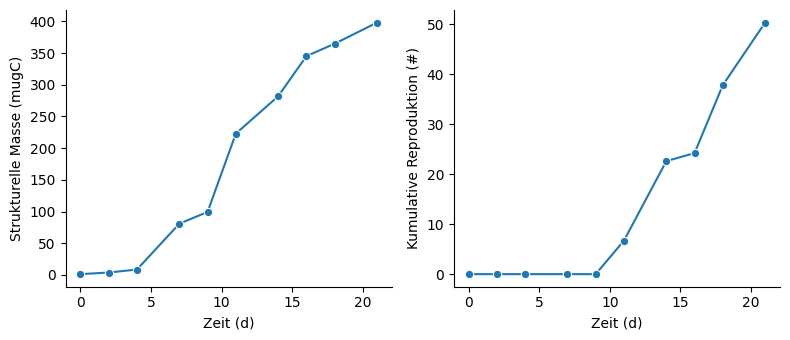

In [13]:
_ = plot_data(data)

## Schätzung eines einzelnen Parameters

Wir wenden nun den Code in `ModelFitting.py` an, um zunächst nur einen einzelnen Parameter zu schätzen. <br>

Hierzu findet sich wieder eine Vorlage in `Ex02_DEBFitting.py`

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'Idot_max_rel': np.float64(15.217460195069414), 'kappa': np.float64(0.4805236313817648), 'eta_IA_0': np.float64(0.49391549239934907)}


c:\Users\ellar\mem25\content\Part3_DEB\Ex02_DEBFitting.py:226: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  return f


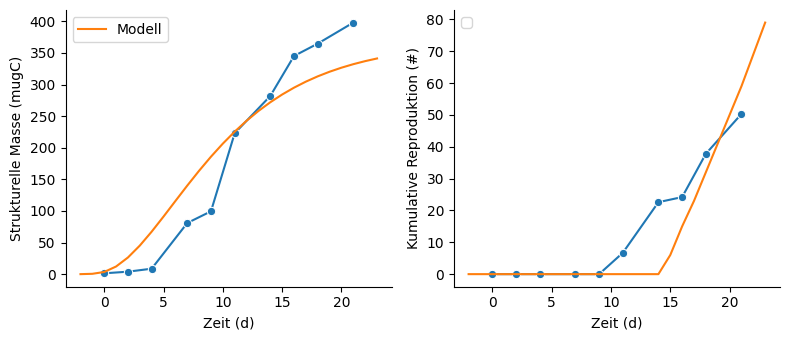

In [16]:
f = fit_model()

In [22]:
f.optimization_result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.00827767162207173
             x: [ 1.171e+01]
           nit: 15
          nfev: 33
 final_simplex: (array([[ 1.171e+01],
                       [ 1.171e+01]]), array([ 8.278e-03,  8.278e-03]))

## Bayessche Inferenz

Auf ähnliche Weise können wir recht einfach eine Bayessche Inferenz mittels SMC-ABC durchführen. <br>

Dazu rufen wir zunächst die Methode `define_lognorm_prior` auf, 
welche das zuvor erlange Ergbenis der lokalen Optimisierung nutzt, um die Prior-Verteilungen als Log-Normalverteilungen zu definieren. <br>

Die Methode `run_bayesian_inference` führt dann den SMC-ABC-Algorithmus aus. 
Mittels `popsize` können wir kontrollieren, wie viele Parameter der Algorithmus pro Kalibrierungsschritt sammelt. `max_total_nr_simulations` gibt die maximale Anzahl an Simulationen an, die während der gesamten Kalibrierung ausgeführt werden. 

Beide Werte sind hier etwas herabgesetzt, damit die Kalibrierung in einigen Minuten durchläuft. Ansonsten ist es bei dieser Art von Kalibrierung nicht unüblich, dass die Laufzeit mehrere Stunden beträgt. 

In [ ]:
f.define_lognorm_prior()
f.run_bayesian_inference(
    # Verringerung der Stichprobengröße, damit wir nicht so lange warten müssen
    # sollte für eine "finale" Kalibrierung entsprechend erhöht werden
    popsize = 250, 
    max_total_nr_simulations = 2_500
)

c:\Users\Simon\anaconda3\envs\MEM25\Lib\site-packages\pyabc\storage\bytes_storage.py:37: UserWarning: Can't find pyarrow, falling back to less efficient csv to store pandas DataFrames.
Install e.g. via `pip install pyabc[pyarrow]`
  return df_to_bytes(object_)
ABC.History INFO: Start <ABCSMC id=2, start_time=2025-02-16 12:23:46>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.80285772e-01.
c:\Users\Simon\anaconda3\envs\MEM25\Lib\site-packages\pyabc\storage\bytes_storage.py:37: UserWarning: Can't find pyarrow, falling back to less efficient csv to store pandas DataFrames.
Install e.g. via `pip install pyabc[pyarrow]`
  return df_to_bytes(object_)
ABC INFO: Accepted: 1000 / 2093 = 4.7778e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.17268109e-01.
c:\Users\Simon\anaconda3\envs\MEM25\Lib\site-packages\pyabc\storage\bytes_storage.py:37: UserWarning: Can't find pyarrow, falling back to less efficient csv to store pandas DataFrames.
Install e.g. via `pip install pyabc[pyarrow]`
  r

Conducted Bayesian inference using SMC-ABC. Results are in `abc_history` and `accepted`


In [ ]:
f.retrodict() # wertet posterior-Stichproben aus
type(f.retrodictions) # Ergebnis ist eine Liste von Vorhersagen

list

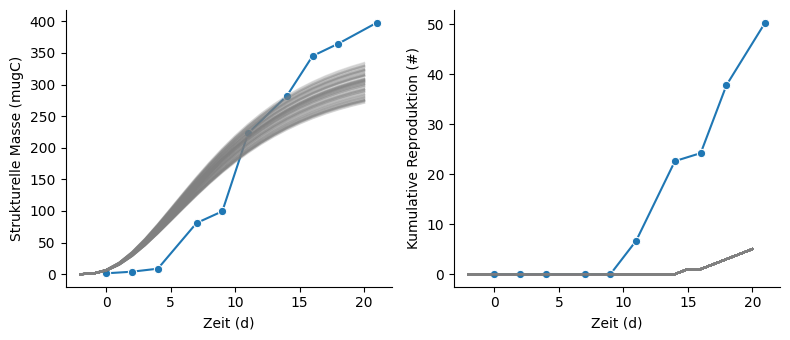

In [ ]:
fig,ax = plot_data(f.data)

for df in f.retrodictions:
    
    sns.lineplot(df, x = 't_day', y = 'S', ax = ax[0], alpha = .2, color = 'gray')
    sns.lineplot(df, x = 't_day', y = 'cum_repro', ax = ax[1], alpha = .2, color = 'gray')


## Aufgabe: Schätzung mehrere Parameter

<div style="border: 1px solid; background-color: #20b2aa; padding: 10px; border-radius: 5px; color: #ffffff">
    <strong>Action:</strong> <br>
    Überlegen Sie, welchen Parameter man zusätzlich kalibrieren könnte, um die Anpassungsgüte des Modells zu verbessern. <br>
    Begründen Sie Ihre Wahl, passen Sie den Code entsprechend an und führen Sie eine erneute Kalbrierung durch. <br>
    Hat sich die Anpassungsgüte verbessert? Warum/warum nicht? <br>
</div>


**Optional**: Fügen Sie der Kalibrierung einen dritten oder vierten Parameter hinzu. Überlegen Sie dabei jeweils zunächst, welche Parameter die Anpassungsgüte am effizientesten verbessern könnten.

### Ihre Lösung

### Musterlösung

Da das Verhältnis zwischen Wachstum und Reproduktion nicht akkurat war, ist es zunächst naheliegend, den Parameter `kappa` zu schätzen (es gibt hier jedoch weitere plausible Optionen).

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'Idot_max_rel': np.float64(24.7625607486416), 'kappa': np.float64(0.4447258466752208)}


C:\Users\Simon\AppData\Local\Temp\ipykernel_9768\4030202714.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


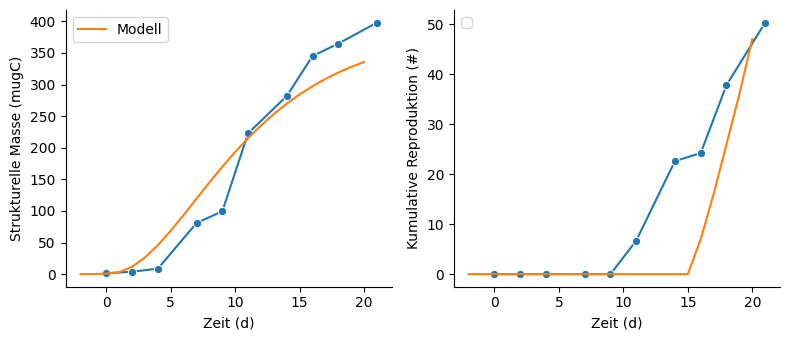

In [ ]:
def fit_model_2params():
    """
    DEB-Modellkalibrierung mit zwei Parametern.
    """

    # Definition des ModelFit - Objektes wie zuvor
    f = setup_modelfit() 
    
    # wir müssen hier lediglich den initial guess anpassen
    f.intguess = { 
        'Idot_max_rel' : f.defaultparams.spc['Idot_max_rel'], 
        'kappa' : f.defaultparams.spc['kappa']
    }

    # am restlichen Code ändert sich ersmtal nichts

    f.run_optimization()

    print(f"Estimated parameter values: {f.p_opt}")

    # simulate optimized parameters, 

    p = deepcopy(f.defaultparams)
    p.spc.update(f.p_opt)  

    sim_opt = f.simulator(p.spc)

    # plot data + retrodiction

    fig, ax = plot_data(f.data)

    sns.lineplot(sim_opt, x = 't_day', y = 'S', ax = ax[0], label = "Modell")
    sns.lineplot(sim_opt, x = 't_day', y = 'cum_repro', ax = ax[1])

    ax[1].legend()

    return f
 
f_2params = fit_model_2params()

Im nächsten Schritt passen wir noch den Struktur-Schwellwert `S_p`. 
Dazu müssen wir auch an der Definition der Simulator-Funktion etwas ändern, da diese `S_p` zuvor intern berechnet hat. <br>
Durch das Schätzen von `eta_AS_0` passen wir noch die Wachstumsrate an, wodurch wir insgesamt einen ganz guten Fit erhalten sollten.

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'Idot_max_rel': np.float64(22.88376226064429), 'kappa': np.float64(0.5265137793254286), 'eta_AS_0': np.float64(0.6767736358373964), 'S_p': np.float64(121.62673237331643)}


C:\Users\Simon\AppData\Local\Temp\ipykernel_9768\2459881511.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


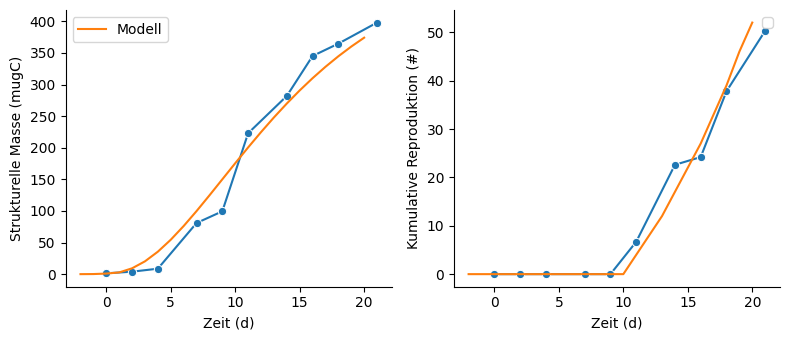

In [ ]:
def define_simulator_4params(f: ModelFit):

    """
    Definition der Simulator-Funktion für DEB-Kalibrierung mit drei Parametern.
    """

    def simulator(theta: dict) -> tuple: # theta = rand(priors)

        p = deepcopy(f.defaultparams)
        p.spc.update(theta) 

        S_max_theta = calc_S_max(p.spc) # implizierte maximale Struktur auf basis von theta
        zoom_factor_theta = S_max_theta / S_MAX_REFERENCE # zoom factor auf basis von theta
        
        # diese Parameter skalieren mit der neuen maximalen Größe

        p.spc['Idot_max_rel_emb'] *= zoom_factor_theta**(1/3)
        p.spc['X_emb_int'] *= zoom_factor_theta
        #p.spc['S_p'] *= zoom_factor_theta
        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            prediction = simulate_DEBBase(p).assign(
                cum_repro = lambda df : np.trunc(df.R / p.spc['X_emb_int']).shift(EMB_DEV_TIME, fill_value = 0)
                ).rename({'t' : 't_day'}, axis = 1)

            return prediction
        
    return simulator

def fit_model_4params():
    """
    DEB-Modellkalibrierung mit 4 Parametern.
    """

    # Definition des ModelFit - Objektes wie zuvor
    
    f = setup_modelfit() 
    
    f.simulator = define_simulator_4params(f)

    f.intguess = { 
        'Idot_max_rel' : f.defaultparams.spc['Idot_max_rel'], 
        'kappa' : f.defaultparams.spc['kappa'],
        'eta_AS_0' : f.defaultparams.spc['eta_AS_0'],
        'S_p' : 100. # geschätzter Anfangswert auf Basis der Abbildung
    }

    f.run_optimization()

    print(f"Estimated parameter values: {f.p_opt}")

    # simulate optimized parameters, 

    p = deepcopy(f.defaultparams)
    p.spc.update(f.p_opt)  

    sim_opt = f.simulator(p.spc)

    # plot data + retrodiction

    fig, ax = plot_data(f.data)

    sns.lineplot(sim_opt, x = 't_day', y = 'S', ax = ax[0], label = "Modell")
    sns.lineplot(sim_opt, x = 't_day', y = 'cum_repro', ax = ax[1])

    ax[1].legend()

    return f
 
f_4params = fit_model_4params()

Das sieht ganz zufriedenstellend aus. <br>
Um die Kalibrierung abzuschliessen, führen wir nun noch einmal die Bayessche Inferenz durch.

In [77]:
f_4params.define_lognorm_prior()

# händische Definition von Prior-Verteilungen für Parameter, die zwischen 0 und 1 liegen müssen
f_4params.prior['kappa'] = pyabc.RV("uniform", 0.25, 0.5)
f_4params.prior['eta_AS_0'] = pyabc.RV("uniform", 0.3, 0.6)

In [78]:
f_4params.run_bayesian_inference(
    popsize = 250, 
    max_total_nr_simulations = 2_500
)

c:\Users\Simon\anaconda3\envs\MEM25\Lib\site-packages\pyabc\storage\bytes_storage.py:37: UserWarning: Can't find pyarrow, falling back to less efficient csv to store pandas DataFrames.
Install e.g. via `pip install pyabc[pyarrow]`
  return df_to_bytes(object_)
ABC.History INFO: Start <ABCSMC id=4, start_time=2025-02-16 14:18:23>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.88734574e-01.
c:\Users\Simon\anaconda3\envs\MEM25\Lib\site-packages\pyabc\storage\bytes_storage.py:37: UserWarning: Can't find pyarrow, falling back to less efficient csv to store pandas DataFrames.
Install e.g. via `pip install pyabc[pyarrow]`
  return df_to_bytes(object_)
ABC INFO: Accepted: 250 / 539 = 4.6382e-01, ESS: 2.5000e+02.
ABC INFO: t: 1, eps: 1.24019854e-01.
c:\Users\Simon\anaconda3\envs\MEM25\Lib\site-packages\pyabc\storage\bytes_storage.py:37: UserWarning: Can't find pyarrow, falling back to less efficient csv to store pandas DataFrames.
Install e.g. via `pip install pyabc[pyarrow]`
  ret

Conducted Bayesian inference using SMC-ABC. Results are in `abc_history` and `accepted`


Die Posterior-Verteilungen können wir wie folgt visualisiern:

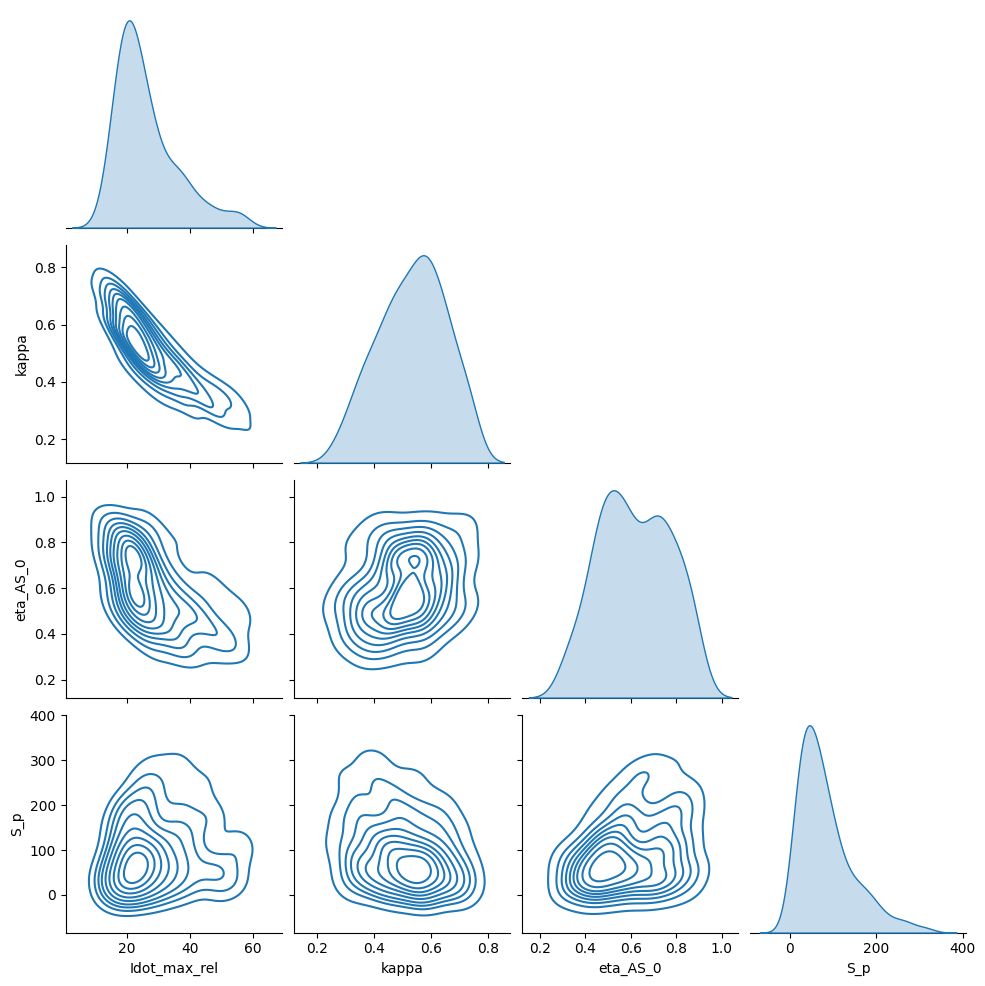

In [79]:
def posterior_pairplot(f: ModelFit):
    sns.pairplot(
        f.accepted[f.prior.keys()], 
        kind = 'kde',
        diag_kind = 'kde', 
        diag_kws = {'weights': f.accepted.weight}, 
        corner = True
        )
    
posterior_pairplot(f_4params)

Der Posterior-Verteilungen zeigen recht hohe Unsicherheiten in den Parametern, vor allem in Bezug auf den Parameter `S_p`. Das spiegelt sich auch in den Retrodiktionen wieder:

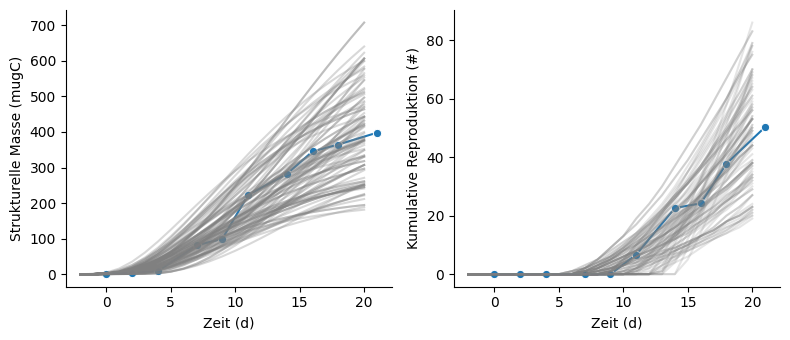

In [81]:
f_4params.retrodict()

fig,ax = plot_data(f_4params.data)

for df in f_4params.retrodictions:
    
    sns.lineplot(df, x = 't_day', y = 'S', ax = ax[0], alpha = .3, color = 'gray')
    sns.lineplot(df, x = 't_day', y = 'cum_repro', ax = ax[1], alpha = .2, color = 'gray')


Da wir mittels lokaler Optimisierung ein gutes Ergebnis erzielt hatten, liegt hier der Verdacht nahe, dass wir die Stichprobenanzahl noch um einiges erhöhen müssen, um eine verlässliche Charakterisierung der Posterior-Verteilung zu erhalten.

Das lässt sich auch durch *Konvergenz-Kriterien* beurteilen, mit denen wir uns hier aber nicht weiter beschäftigen werden.